In [1]:
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import gzip
import ndjson
from tqdm import tqdm

import matplotlib.pyplot as plt

import torch

from transformers import AutoTokenizer, AutoModelForCausalLM

# Analyzing Arxiv Data
The purpose of this notebook is to make sure I am filtering arXiv.math properly for inclusion in the proof-pile. 

We are working on commit `d2ed9e500d8df9db25a6e5c86139a196d700a22e` 

In the main data cleaning script `fetch_arxiv.py`, we apply the following preprocessing steps to source files
- Delete everything outside of `\begin{document}` and  `\end{document}` 
- Delete everything including and after `\Refs` or `\begin{thebibliography}`, `\begin{references}`. 
- Delete comments

After preprocessing, we include a file in the dataset only if it meets the following criteria.
- `.tex` extension. 
- At least 280 characters. 
- Using `utf-8`, `utf-16`, `utf-32`, or `latin-1` text encoding. 
- Articles is in English, as determined by the [langdetect library](https://pypi.org/project/langdetect/). 

The above is the data that is on the current huggingface page. 

In the file `run1_postprocessing/make_files.py`, we apply the following additional preprocessing steps to produce the final data that proof-GPTv0.1 is trained on.
- Delete files that do not contain a part, chapter, section, sub...section, paragraph, or subparagraph heading. 
- Delete files that contain the keyword "gnuplot". The Gnuplot-latex utility generates large blocks of basically unintelligible source. 
- Delete everything including and enclosed by `\begin{bibdiv}` and `\end{bibdiv}`. 
- `>3` consectuive newlines are replaced with 3 newlines. 

### Strategy
These preprocessing heuristics are informed by $\LaTeX{}$ expertise and manual inspection of data. However, I am not aware of every single subtelty of $\LaTeX$, and I can only inspect so many training examples. Therefore, I am still not confident these heuristics yield a clean dataset.

In this notebook I try to detect noise in the dataset by identifying documents that achieve a large loss when processed by an off-the-shelf pre-trained language model, specifically `EleutherAI/gpt-neo-125M`. 

In [2]:
# load subset of data
print("loading data batch...")
fle_name = "/data/corpora/proof-pile/train/proofpile_train_0.jsonl"
with open(fle_name) as f: 
    data = ndjson.load(f)

loading data batch...


In [3]:
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/gpt-neo-125M").cuda()

tokenizer = AutoTokenizer.from_pretrained(
    "EleutherAI/gpt-neo-125M")

tokenizer.pad_token = tokenizer.eos_token

context = 2048

In [4]:
n = 1000

# only look at arxiv. The rest of the data is very high quality and is definitely clean.
tiny = [x for x in data[:n] if "config" in x["meta"] and x["meta"]["config"]=="arxiv"]

print(f"full batch length: {len(data)}")
print(f"working subset length: {len(tiny)}")

full batch length: 100000
working subset length: 717


As a sanity check, we append a random string of alphanumeric characters to our data. This should achieve a very high loss.

In [5]:
import random
import string
tiny.append({"text": ''.join(random.choices(string.ascii_uppercase + string.digits, k=8000))})

In [6]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='none')

batch_size = 15

print("We're going to get an indexing warning, ignore it.")
for i in tqdm(range(len(tiny))): 
    example = tiny[i]
    
    tokens = tokenizer([example["text"]], 
                    return_tensors="pt", 
                    padding=True, 
                    pad_to_multiple_of=context)
        
    tokens = {key: tokens[key].reshape((-1, context)).cuda() for key in tokens}   
    
    labels = tokens["input_ids"].clone()
        
    unreduced_loss = 0
    num_tokens = 0 
    for j in range(0, tokens["input_ids"].shape[0], batch_size):
        this_ids = tokens["input_ids"][j:j+batch_size, :]
        this_mask = tokens["attention_mask"][j:j+batch_size, :]
        this_labels = labels[j:j+batch_size, :]
    
        with torch.no_grad():
            out = model(input_ids=this_ids, attention_mask=this_mask)
    
        preds = out.logits[:, :-1, :]
            
    
        preds = preds.flatten(end_dim=1)
        flat_labels = this_labels[:, 1:].flatten()
        flat_mask = this_mask[:, 1:].flatten()
                
        unreduced_loss += torch.sum(loss_fn(preds, flat_labels)*flat_mask).item()
        num_tokens += torch.sum(flat_mask).item()
    
    loss = unreduced_loss/num_tokens       
                      
    tiny[i]["loss"] = loss

We're going to get an indexing warning, ignore it.


100%|███████████████████████████████████████████████████| 718/718 [08:48<00:00,  1.36it/s]


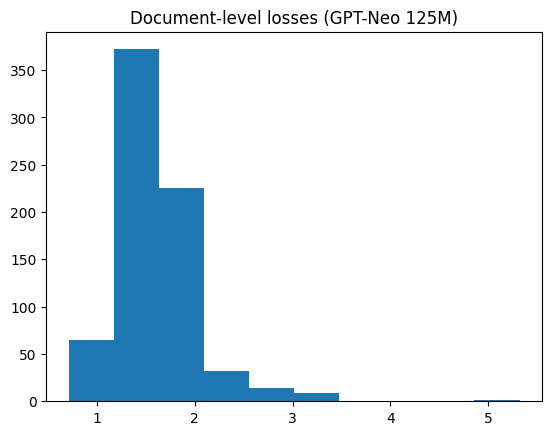

In [7]:
losses = [x["loss"] for x in tiny]
plt.hist(losses)
plt.title("Document-level losses (GPT-Neo 125M)")
plt.show()

In [8]:
print("random sequence loss: ", tiny[-1]["loss"])
print(tiny[-1]["text"][:100], "...")

random sequence loss:  5.31893930607105
WNQ3LEC13MBO5UM7EM34EYH9HJ6V1R08QOCG4C0SZTOL6DCUVACX1IO1PRGZ7GPSN759YA206SWGQXPMG8CR2CEYHJGPZ9YV8HAU ...


In [9]:
ordered_idxs = sorted(list(range(len(tiny))), key = lambda i: -tiny[i]["loss"])

print("Index of 10 documents with highest loss")
print(ordered_idxs[:10])

Index of 10 documents with highest loss
[717, 46, 238, 352, 197, 33, 520, 502, 139, 403]


In [10]:
idx = 1
print("loss : ", tiny[ordered_idxs[idx]]["loss"])
print(tiny[ordered_idxs[idx]]["text"])

loss :  3.4214292093012535
\section{Discussion}
\label{sec:Discussion}

In this paper, we have provided a new method for the featurization of persistence diagrams through the use of template functions; that is, collections of functions compactly supported on the upper half plane away from the diagonal whose induced functions on diagrams separate points.
To do this, we further gave a complete description of compact sets in persistence diagram space endowed with the bottleneck distance.

This method of featurization allows for a great deal of flexibility for the end user.
In particular, we have provided two options for template functions, tent functions and interpolating polynomials, but surely there are many other collections of functions which could be tested for optimizing classification and regression tasks.
We showed these two functions worked quite well on standard experiments, as well as in comparison to other methods available in the literature.

We find the particular results of

### Discussion
In the cell above, we can set `idx = n` to view the document that generates `n`th highest loss. We can see, even the documents that yield the highest losses look like high quality, useful data. This means we can be relatively confident our pre-training data is free of complete noise. 